In [2]:
!pip install pandas seaborn matplotlib numpy scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    object 
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), object(2)
memory usage: 17.1+ KB
None
         date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0  2023-01-01        23.745401  46.140905        7.845981        Rain   
1  2023-01-02        30.030503  59.876587        5.382457        Rain   
2  2023-01-03        28.365224  51.464618       13.158008        Rain   
3  2023-01-04        27.550929  53.103799        5.886677        Rain   
4  2023-01-05        23.639303  57.826186       12.248992  

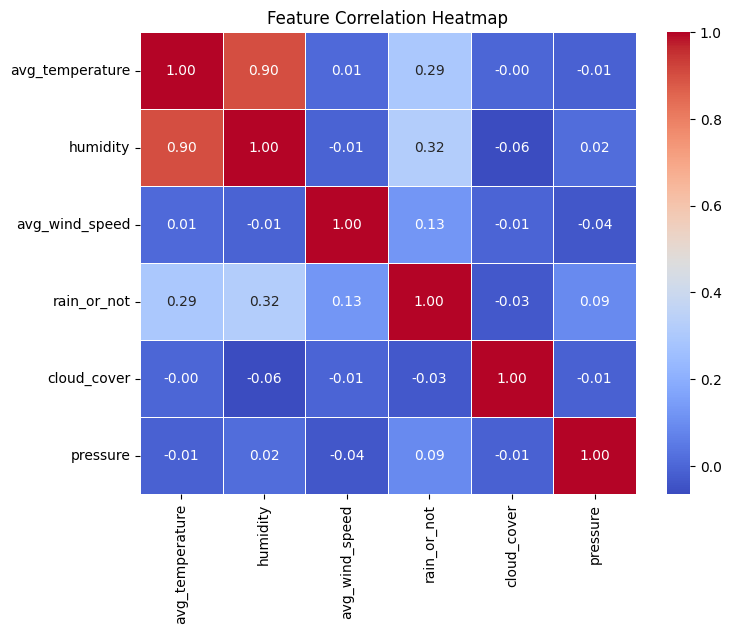

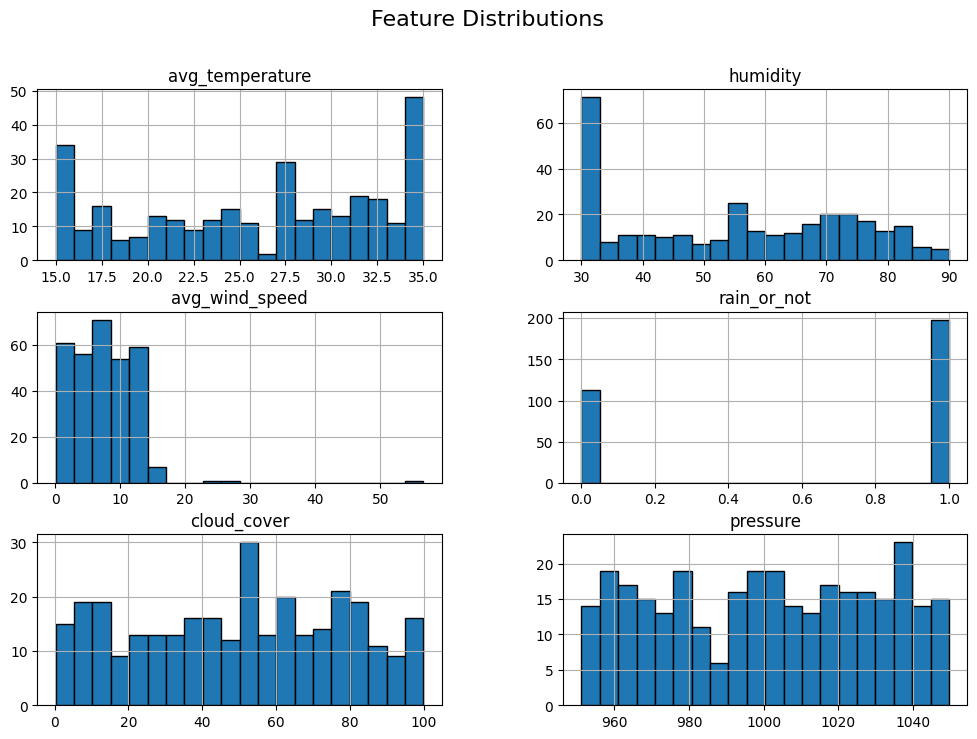

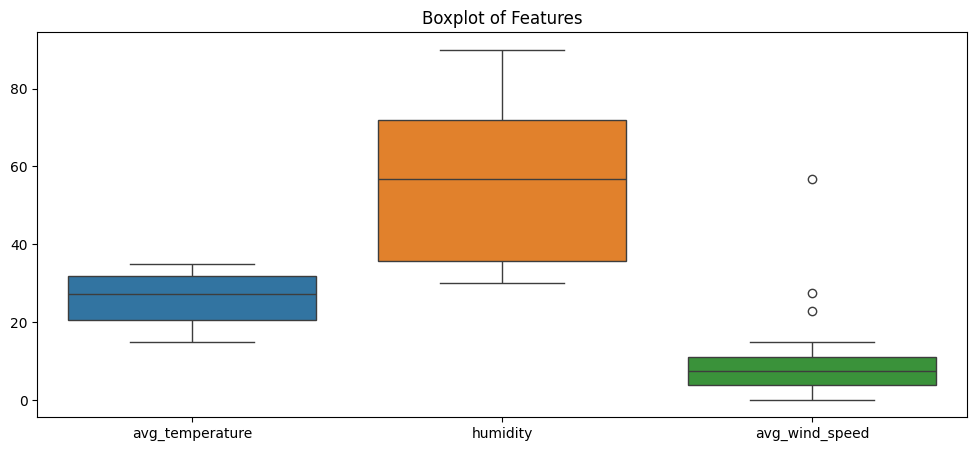

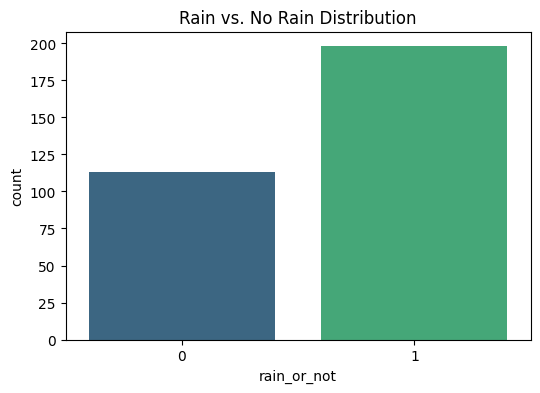

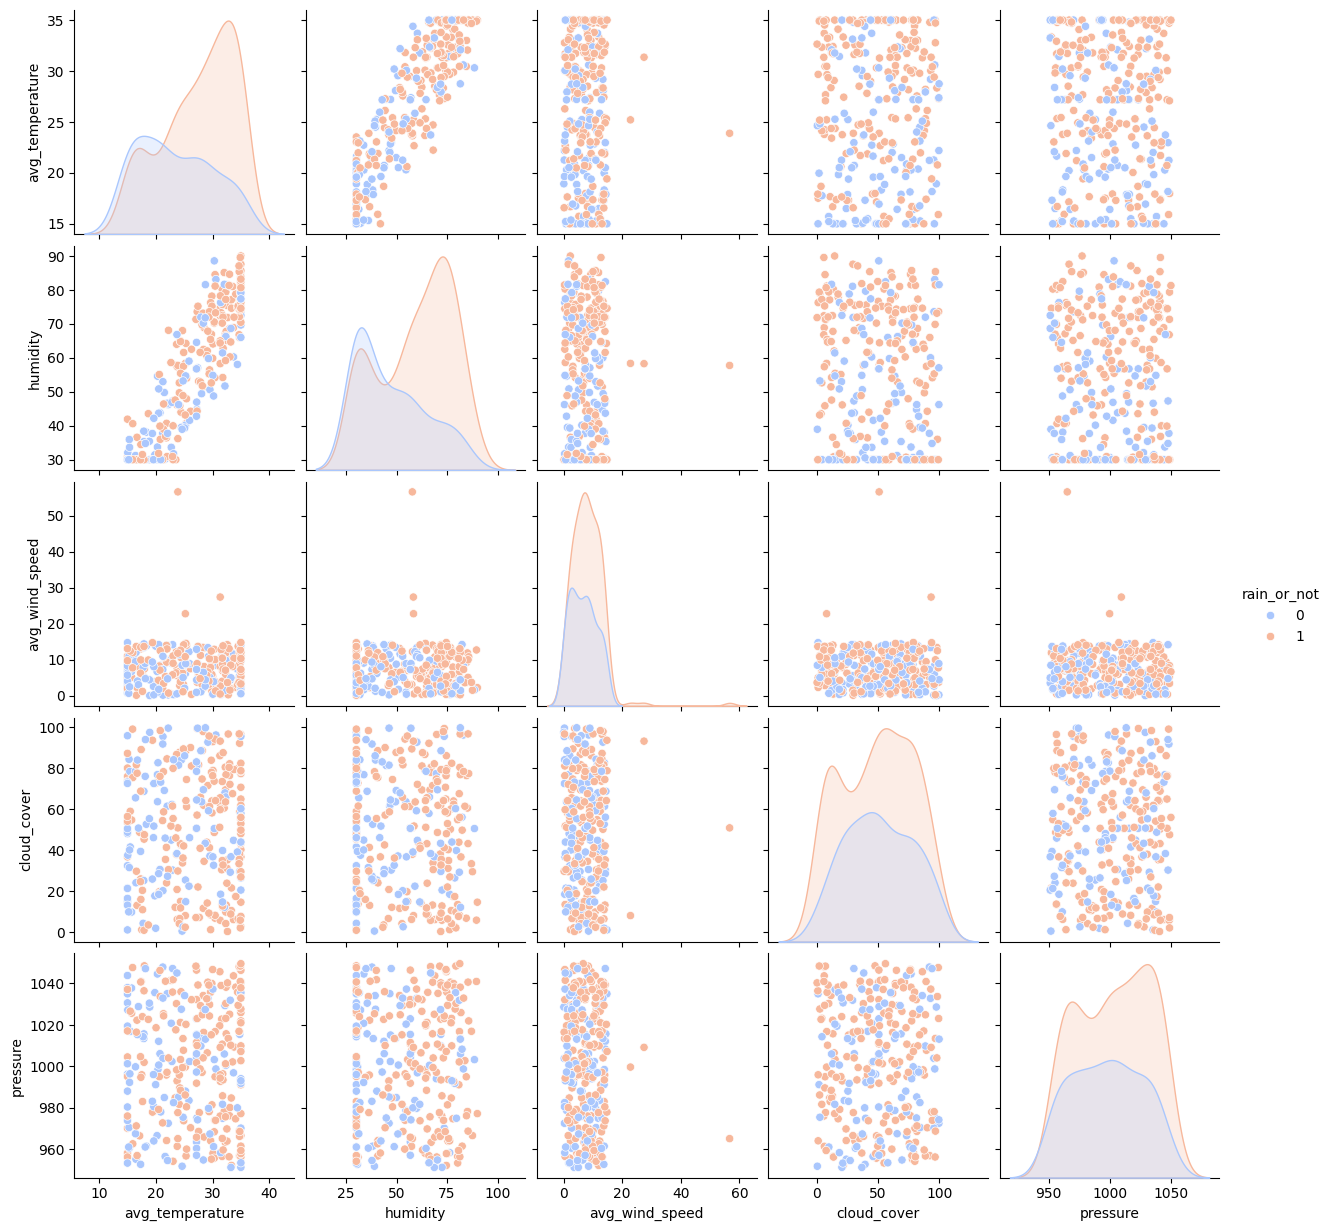


Logistic Regression Results:
Accuracy: 0.6825396825396826
ROC AUC Score: 0.5831485587583148
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.45      0.50        22
           1       0.73      0.80      0.77        41

    accuracy                           0.68        63
   macro avg       0.64      0.63      0.63        63
weighted avg       0.67      0.68      0.67        63


Decision Tree Results:
Accuracy: 0.5238095238095238
ROC AUC Score: 0.4761640798226165
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.32      0.32        22
           1       0.63      0.63      0.63        41

    accuracy                           0.52        63
   macro avg       0.48      0.48      0.48        63
weighted avg       0.52      0.52      0.52        63


Random Forest Results:
Accuracy: 0.5714285714285714
ROC AUC Score: 0.5548780487804877
Classification Report:
        

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Load dataset
df = pd.read_csv("weather_data.csv")  # Replace with your actual file path

# Display basic info
print(df.info())
print(df.head())

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Encode 'rain_or_not' as binary (1 for Rain, 0 for No Rain)
df['rain_or_not'] = df['rain_or_not'].str.strip().map({'Rain': 1, 'No Rain': 0})

# Fill missing values using median
df.fillna(df.median(), inplace=True)

# Drop 'date' as it's not a numerical feature
df.drop(columns=['date'], inplace=True)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Boxplots to detect outliers
plt.figure(figsize=(12, 5))
sns.boxplot(data=df[['avg_temperature', 'humidity', 'avg_wind_speed']])
plt.title("Boxplot of Features")
plt.show()

# Rain vs. No Rain count plot
plt.figure(figsize=(6, 4))
sns.countplot(x="rain_or_not", data=df, hue="rain_or_not", palette="viridis", legend=False)
plt.title("Rain vs. No Rain Distribution")
plt.show()

# Pairplot to visualize feature relationships
sns.pairplot(df, hue="rain_or_not", diag_kind="kde", palette="coolwarm")
plt.show()

# Split data into training and test sets
X = df.drop(columns=['rain_or_not'])
y = df['rain_or_not']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate models
best_model = None
best_score = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy)
    print("ROC AUC Score:", roc_auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Select the best model dynamically
    if accuracy > best_score:
        best_score = accuracy
        best_model = model

print(f"\nBest Model: {best_model.__class__.__name__} with Accuracy: {best_score}")

# Hyperparameter tuning for best model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

if isinstance(best_model, RandomForestClassifier):
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

# Use the best model to make predictions for the next 21 days
future_features = X.tail(21)  # Assuming last 21 rows represent future dates
future_features = scaler.transform(future_features)
future_predictions = best_model.predict_proba(future_features)[:, 1]

# Output probability of rain for next 21 days
print("\nRain Probabilities for Next 21 Days:", future_predictions)
